If you are running this on Colab, run the pip below. If you are on Anaconda, I would recommend installing through normal ways instead of the pip below.

In [5]:
!pip install scikit-optimize

  Using cached scikit_optimize-0.10.2-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached pyaml-24.9.0-py3-none-any.whl.metadata (11 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.7 MB/s eta 0:00:00
Using cached pyaml-24.9.0-py3-none-any.whl (24 kB)


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

from sklearn.metrics import *
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import pandas as pd

from matplotlib.patches import Patch
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import (
    KFold,
    ShuffleSplit,
    StratifiedKFold,
    StratifiedShuffleSplit,
    TimeSeriesSplit)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
import warnings
warnings.filterwarnings("ignore")

### Evaluating a model

So far to see how well our model performs, we looked either at the confusion matrix or accuracy. However, there are other ways to see how good our model is that can be better depending on what we are trying to achieve. Suppose we have some binary classification model whose confusion matrix is as follows:

$$\begin{bmatrix} 5 & 5 \\ 10 & 180 \end{bmatrix}$$

As a reminder, each row shows actual class and each column shows predicted class.
We can see that we got $5+180=185$ correct predictions and $5+10=15$ incorrect predictions and so our precision is $185/200=0.925$, which is quite good.

So, let's look at our first class a bit more carefully. Notice that we predicted first class $15$ times and out of those $15$ times, we were correct $5$ times. In other words, our rate of being correct is $5/15=0.33$, which is not as good. This rate is called "Precision". Each class would have its own precision.

We can also look at how often we classified our first class correctly. So, in this example we have $10$ data points in the the first class and we classified only $5$ of them correctly. So, our rate is $5/10=0.5$. This rate is called "Recall". Again, we can calculate Recall for each class.

Notice we can fudge our parameters to make our precision or recall high. For example, if I just make every prediction to be class 1, then I will not miss any of the class 1 points, and so my Recall will be 1. However, in this case my Precision will drop even further. On the other hand, if I classify class 1 only when I am 100% sure it is class 1, then my Precision will go up, but Recall will drop. To balance these two measure, we use F1-score:

$$F1=\frac{2\cdot Precision \cdot Recall}{Precision+Recall}$$

To summarize, suppose we consider first class as Positive and second class as Negative. Our confusion matrix will take the following form then:
$$\begin{bmatrix} TP & FN \\ FP & TN \end{bmatrix}$$

Here $TT$ stands for True Positive, $FN$ for False Negative, $FP$ False Positive and $FF$ for True Negative. Then,
$$Precision=\frac{TP}{TP+FP}$$
$$Recall=\frac{TP}{TP+FN}$$

If we have more than two classes, we have two approaches. We calculate Precision and Recall for each class separatelly considering remaining classes as a single class. Then we either just consider these values or take their average.

Note: Techically, there are two ways to do averaging out as well:
1. We can get Precision and Recall for each class and average that (Macro Averaging), or
2. We can get all $TP$, $FP$ and $FN$ for each class, find total of each and calculate total Precision and Recall. (Micro Averaging)

Last evaluation techiques we will discuss are "ROC" and "AUC".

Suppose we still have binary classification. We classify a point to be in class 1 by some probability threshold. In other words, if a model gives us a probability that is higher than some threshold value, we classify our point as class 1.

A "ROC" curve is a plot of False Positive Rate ($FPR$) versus True Positive Rate ($TPR$) taking over all threshold values, where
$$FPR=\frac{FP}{FP+TN},$$
$$TPR=\frac{TP}{TP+FN}=Recall$$

So, $FPR$ is rate of getting incorrect predictions on non-class 1 data and $TPR$ is correct prediction of class 1 (i.e. Recall). We want $FPR$ to be low and $TPR$ to be high. Since each rate is a value between 0 and 1, we will have a graph somewhere in the $[0,1] \times [0,1]$:


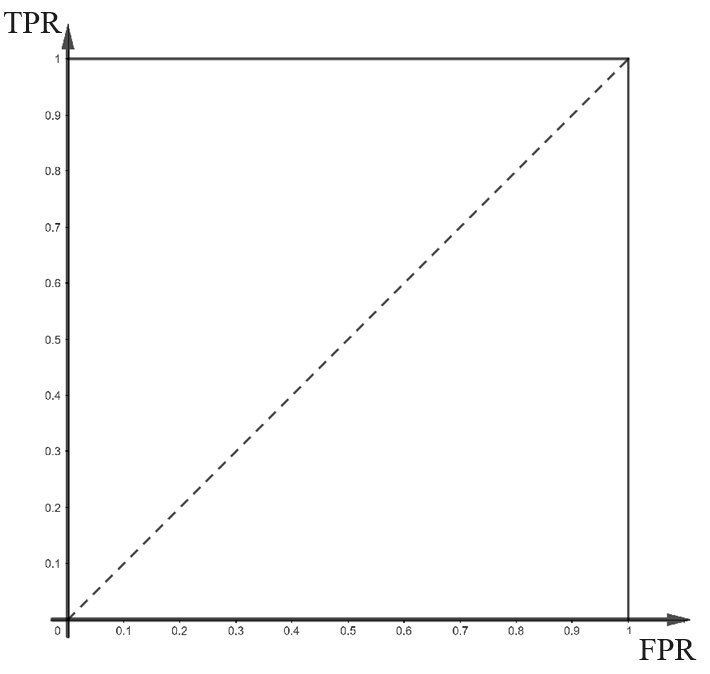

Best case scenario is when FPR is zero and TPR is 1 (so top left corner). The dotted line corresponds to basically random guess, so we definatelly do not want to be below this curve.

If we set our threshold to zero, then everything is being classified as Class 1, so out TRP is high, but our FPR is also high since nothing is being classifed as Class 2. That gives us a point in the top right corner. On the other hand, if out threshold is set to 1, then everything is classified as Class 2, so both TPR and FPR are low. Now we are in the bottom left corner.

As we move from zero threshold up, our TPR and FPR should increase, but if model is somewhat good, TPR will increase much more than FPR. As we go over all threshold values, our ROC curve will look somewhat like this:

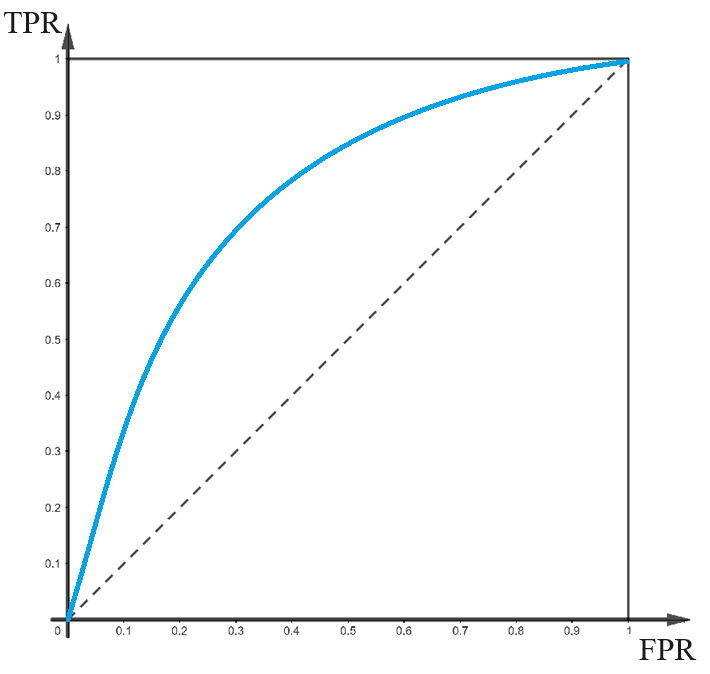

Visually, the closer the curve is to top left corner, the better. To quantify this we use AUC (Area Under the Curve). It is a bit of simplication of a curve, but it is used often. The idea is the closer our curve is to upper left corner, the higher area of under the curve.

### Example

Let't apply all above measures to one of the classification model. We will use Logistic Regression on Cancer Dataset.

In [7]:
dataset=datasets.load_breast_cancer()
X, y = dataset.data, dataset.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [8]:
model = DecisionTreeClassifier(criterion="gini", min_impurity_decrease=.01, min_samples_leaf=5,max_depth=3,max_features=5)
model.fit(X_train, y_train)
predictions =model.predict(X_test)


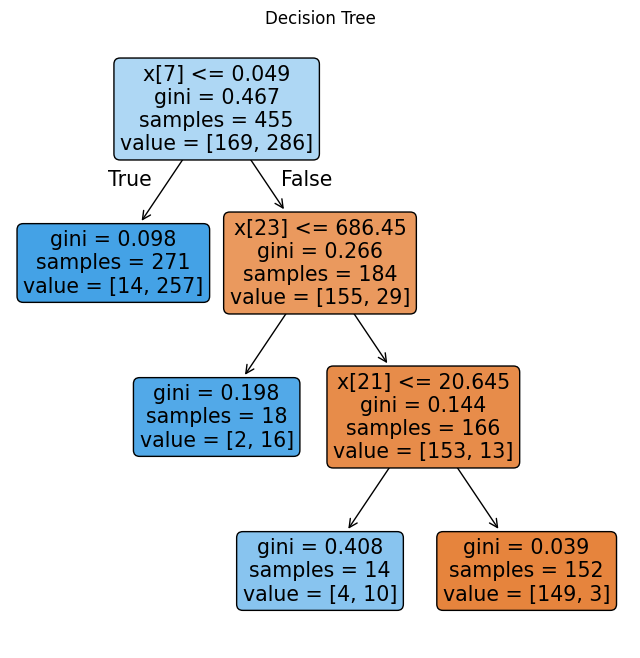

In [9]:
plt.figure(figsize=(8, 8))
plot_tree(model, filled=True, rounded=True)
plt.title("Decision Tree")
plt.show()

In [10]:
print('Confusion Matrix = \n',confusion_matrix(y_test, predictions))
print('Accuracy =',accuracy_score(y_test, predictions))
print('Precision =',precision_score(y_test, predictions))
print('Recall =',recall_score(y_test, predictions))
print('F1 score =',f1_score(y_test, predictions))
fpr, tpr, thresholds = roc_curve(y_test, predictions)
print('AUC = ',auc(fpr, tpr) )

Confusion Matrix = 
 [[33 10]
 [ 0 71]]
Accuracy = 0.9122807017543859
Precision = 0.8765432098765432
Recall = 1.0
F1 score = 0.9342105263157895
AUC =  0.8837209302325582


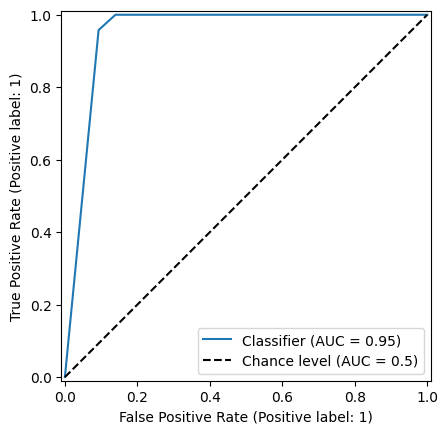

In [11]:
prob=model.predict_proba(X_test)[:,1]
RocCurveDisplay.from_predictions(y_test, prob,plot_chance_level=True)
plt.show()

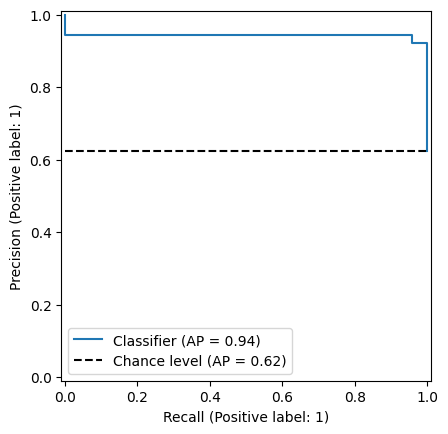

In [12]:
PrecisionRecallDisplay.from_predictions(y_test, prob, plot_chance_level=True)
plt.show()

### Regression metrics

Most common metrics on regression are "R2-score", "Mean Squared Error", "Mean Absolute Error" and "Root Mean Squared Error".

### Cross-validation

So far when we want to train the model, we split our data into two parts: training set and testing set. We train our model on training set, validate it on testing. This is done to avoid overfitting. However, there are a few drawbacks:
1. When we validate our model we use only small amount of data.
2. If our classes are very uneven, we may get unlucky with a split to have good model.
3. If our data set is small, then testing set is very tiny and so accuracy score is not very telling on how good the model is.

It would be nice if somehow we could use more of our data to validate the model without contamination. For that, we use Cross-Validation.

The simplest version of CrossValidation is called K-fold Cross Validation. We split our data into K equal size subsets and we train K models, each time using one of those subsets as validation set. We measure accuracy of each model and get the total accuracy of the model as average of all accuracies of sub-models.

Few things to note:
1. This improves our validation, but increases our complexity.
2. Each sample is included in validation and in training.
3. This reduces variance and bias of our model.
4. Usual number for K is 5 or 10.

Let's see how this works. I will use a small function for visualization.

In [13]:
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=None)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['class']
    ax.set(yticks=np.arange(n_splits+1) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+1.2, -.1], xlim=[0, X.shape[0]])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

Let's apply this to our training set.

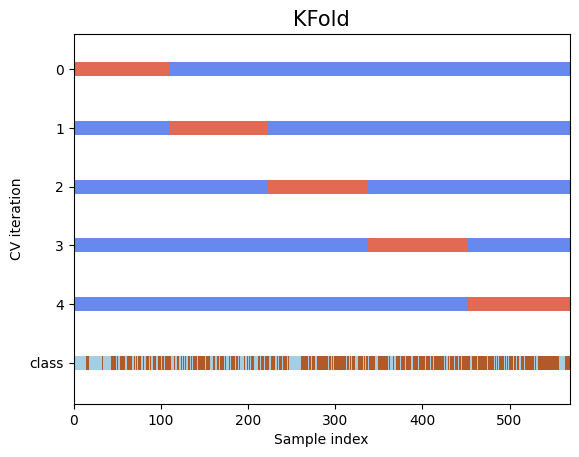

In [14]:
n_splits = 5
cv = KFold(n_splits)

fig, ax = plt.subplots()
plot_cv_indices(cv, X, y, ax, n_splits)
plt.show()

Let's see how it deals wit our Decision tree model

In [15]:
scores=cross_val_score(model, X_train, y_train, cv=5)
scores

array([0.92307692, 0.89010989, 0.87912088, 0.93406593, 0.94505495])

In [16]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.91 accuracy with a standard deviation of 0.03


We can use other measures besides accuracy as well. Here is an example with F1-score:

In [17]:
fscores=cross_val_score(model, X_train, y_train, cv=5,scoring='f1_macro')
fscores

array([0.91369733, 0.8907563 , 0.94017094, 0.92868339, 0.92956656])

In [18]:
print("%0.2f f1-score with a standard deviation of %0.2f" % (fscores.mean(), fscores.std()))

0.92 f1-score with a standard deviation of 0.02


### Other Cross Validation techniques

1. StratifiedKFold tries to preserve the percentage of samples for each class.
2. ShuffleSplit does random splitting
3. TimeSeriesSplit assumes the data is ordered in time, so current data can be only influenced by past data.

We can also introduce Groups. Suppose all our patients were diagnosed by a few specific doctors. Our data may get a bit grouped based on which doctor diagnosed the tumor. We want to make sure that all samples in validation part come from groups that are not in training set. But this part is a bit outside of our discussion.

Here are examples, of some of the splits:

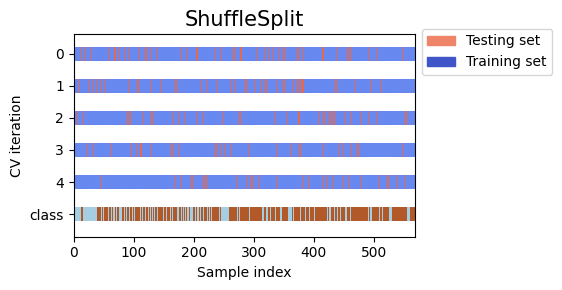

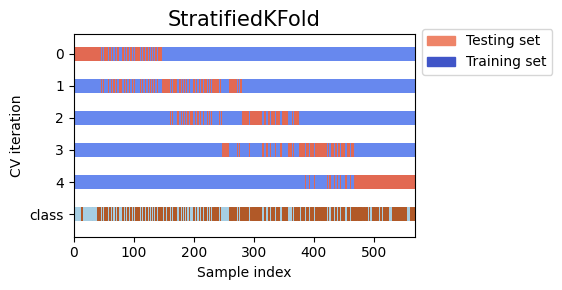

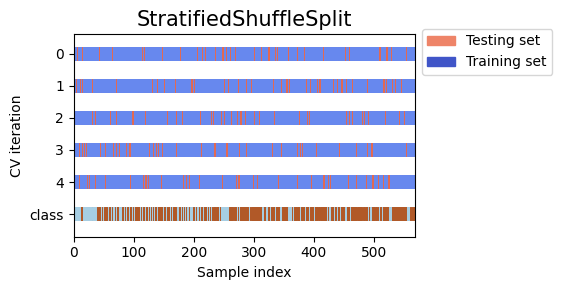

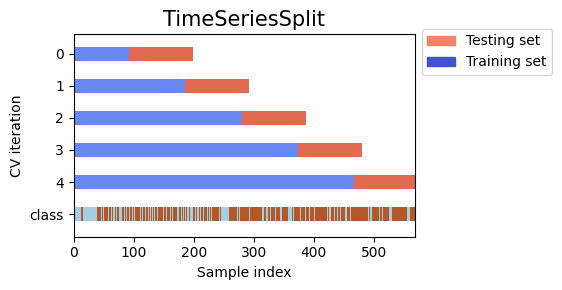

In [20]:
cvs = [
    ShuffleSplit,
    StratifiedKFold,
    StratifiedShuffleSplit,
    TimeSeriesSplit]

for cv in cvs:
    this_cv = cv(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(6, 3))
    plot_cv_indices(this_cv, X, y, ax, n_splits)

    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)
plt.show()

### Hyper-Parameter Tuning and Model Selection

No matter what model we pick, we have to make some choices about hyper parameters. For example, in our Decision Tree example above, we need to pick criterion, max_depth, min_impurity_decrease, max_features, etc. How do we know what to pick? For some, it may be easy based on what we are trying to see, but usually we just want to optimize our metrics. Moreover, we can consider multiple models as well at the same time. So, we can optimize model choice with corresponding hyper-parameters.

Main approach involves considering a space of hyperparameters, creating many models with various combination of parameters and seeing which performs better. The simplest (or brute force) method is to use GridSearchCV. It involves looking at every possible combination of parameters. Note it also uses crossvalidation (`cv`) to get the score.

I am going to consider the dataset we already have a decision tree model as my first example. I will try to look at max_features, criterion, max_depth and min_impurity_decrease.

In [21]:
param_dist  = {
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [2,3,4, 5, 6],
              'criterion' :['gini', 'entropy']
             }

In [22]:
model = DecisionTreeClassifier()
tree_cv = GridSearchCV(model, param_dist, cv=5)

tree_cv.fit(X, y)
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'ccp_alpha': 0.01, 'criterion': 'entropy', 'max_depth': 4}
Best score is 0.9420121099208197


Few notes:

1. If you rerun this cell, you may get different results. This happens for a few reasons. Due to randomness of crossvalidation, we may be getting different minimums. Moreover, these parameters may not change our score by a lot, so in essence they are close to each other.
2. Generally, do not expect GridSearch to change your results by a lot (this does apply to other search methods below)
3. GridSearch is very expensive as it literally checks every possibility.

To combat last point, we can use RandomizedSearchCV or Bayesian Optimization. RandomizedSearchCV chooses few combinations from our parameter space at random and tests only those. This will speed up our tuning, but an obviuous drawback is that we may not be able to get minimum. Bayesian Optimization is similar to RandomizedSearchCV but is treated as optimization problem, in which every combination is given the same probability of being chosen at the start. If a randomly chosen combination has poor score, its probability and the probability of nearby combinations is lowered, so there is less chance of being picked.

In [23]:
models_list = [LogisticRegression(max_iter=1000), SVC(), DecisionTreeClassifier()]

model_hyperparameters = {
    'log_reg_hyperparameters': {
        'C' : [1,5,10,20] },

    'svc_hyperparameters': {
        'kernel' : ['linear','poly','rbf','sigmoid'],
        'C' : [1,5,10,20] },

    'random_forest_hyperparameters' : {
        'criterion' :['gini', 'entropy'],
         'max_depth' : [2,3,4, 5, 6] }
}

model_keys = list(model_hyperparameters.keys())

In [31]:
def ModelSelection(list_of_models, hyperparameters_dictionary, cv_type="gs"):

  result = []

  i = 0

  for model in list_of_models:

    key = model_keys[i]

    params = hyperparameters_dictionary[key]

    i += 1

    print(model)
    print(params)
    print('---------------------------------')


    if cv_type=="random":
        classifier = RandomizedSearchCV(model, params, cv=5)
    elif cv_type=="gs":
        classifier = GridSearchCV(model, params, cv=5)
    elif cv_type=="bayes":
        classifier = BayesSearchCV(model, params,n_iter=10, cv=5)
    # fitting the data to classifier
    classifier.fit(X,y)

    result.append({
        'model used' : model,
        'highest score' : classifier.best_score_,
        'best hyperparameters' : classifier.best_params_
    })

  result_dataframe = pd.DataFrame(result, columns = ['model used','highest score','best hyperparameters'])

  return result_dataframe

In [32]:
ModelSelection(models_list, model_hyperparameters, cv_type="gs")

LogisticRegression(max_iter=1000)
{'C': [1, 5, 10, 20]}
---------------------------------
SVC()
{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': [1, 5, 10, 20]}
---------------------------------
DecisionTreeClassifier()
{'criterion': ['gini', 'entropy'], 'max_depth': [2, 3, 4, 5, 6]}
---------------------------------


,model used,highest score,best hyperparameters
0,LogisticRegression(max_iter=1000),0.954324,{'C': 5}
1,SVC(),0.952569,"{'C': 10, 'kernel': 'linear'}"
2,DecisionTreeClassifier(),0.940258,"{'criterion': 'entropy', 'max_depth': 4}"


In [33]:
ModelSelection(models_list, model_hyperparameters, cv_type="random")

LogisticRegression(max_iter=1000)
{'C': [1, 5, 10, 20]}
---------------------------------
SVC()
{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': [1, 5, 10, 20]}
---------------------------------
DecisionTreeClassifier()
{'criterion': ['gini', 'entropy'], 'max_depth': [2, 3, 4, 5, 6]}
---------------------------------


,model used,highest score,best hyperparameters
0,LogisticRegression(max_iter=1000),0.954324,{'C': 5}
1,SVC(),0.952569,"{'kernel': 'linear', 'C': 10}"
2,DecisionTreeClassifier(),0.938503,"{'max_depth': 6, 'criterion': 'entropy'}"


In [34]:
ModelSelection(models_list, model_hyperparameters, cv_type="bayes")

LogisticRegression(max_iter=1000)
{'C': [1, 5, 10, 20]}
---------------------------------
SVC()
{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': [1, 5, 10, 20]}
---------------------------------
DecisionTreeClassifier()
{'criterion': ['gini', 'entropy'], 'max_depth': [2, 3, 4, 5, 6]}
---------------------------------


,model used,highest score,best hyperparameters
0,LogisticRegression(max_iter=1000),0.954324,{'C': 5}
1,SVC(),0.952569,"{'C': 10, 'kernel': 'linear'}"
2,DecisionTreeClassifier(),0.942012,"{'criterion': 'entropy', 'max_depth': 4}"


Finally let's look at combined ROC curves for best choices in the last Model Selection we did

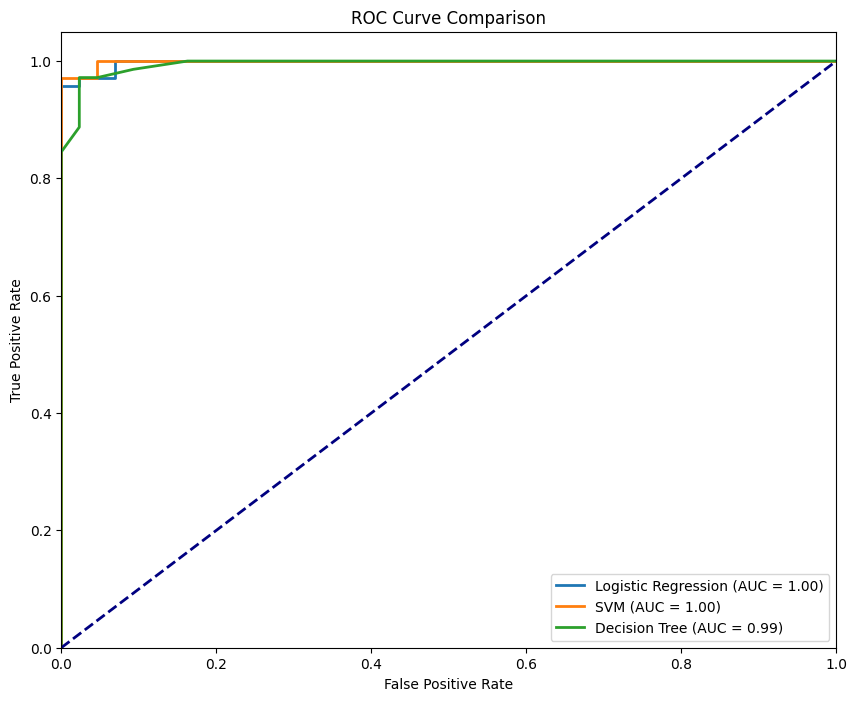

Logistic Regression: AUC - ROC = 1.00
SVM: AUC - ROC = 1.00
Decision Tree: AUC - ROC = 0.99


In [37]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000,C=5),
    "SVM": SVC(probability=True, C=10, kernel='linear'),
    "Decision Tree": DecisionTreeClassifier(criterion='entropy', max_depth=4)
}

roc_auc_scores = {}


plt.figure(figsize=(10, 8))

for name, model in models.items():

    model.fit(X_train, y_train)
    y_probs = model.predict_proba(X_test)[:, 1]

    # Calculate the AUC - ROC score
    roc_auc = roc_auc_score(y_test, y_probs)
    roc_auc_scores[name] = roc_auc

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_probs)

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()

# Print the AUC - ROC scores for each model
for name, score in roc_auc_scores.items():
    print(f'{name}: AUC - ROC = {score:.2f}')